In [60]:
from PIL import Image
from pytesseract import pytesseract
#https://github.com/UB-Mannheim/tesseract/wiki
#https://www.geeksforgeeks.org/how-to-extract-text-from-images-with-python/

### Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and “read” the text embedded in images.

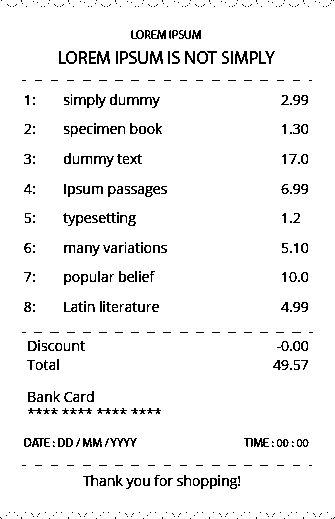

In [61]:
path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
img = Image.open('receipt.png')
#img.show()
display(img)

In [62]:
pytesseract.tesseract_cmd = path_to_tesseract
text = pytesseract.image_to_string(img)
print(text)

 

LOREM IPSUM
LOREM IPSUM IS NOT SIMPLY

 

 

simply dummy 2.99
2: specimen book 1.30
3: dummytext 17.0
4: Ipsum passages 6.99
5: typesetting 12
6: many variations 5.10
7: popular belief 10.0
8: Latin literature 499
“Discount -0.00
Total 49.57
Bank Card

  

Thank you for shopping!



### Detect header

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#https://medium.com/analytics-vidhya/how-to-detect-tables-in-images-using-opencv-and-python-6a0f15e560c3
#https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec

### OpenCV (Open Source Computer Vision Library) is an open source computer vision ( image recognition library) and machine learning software library. 

In [4]:
file = r'receipt.png'
im1 = cv2.imread(file, 0)
im = cv2.imread(file)

In [6]:
ret,thresh_value = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)

In [7]:
kernel = np.ones((5,5),np.uint8)
dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)

In [8]:
contours, hierarchy = cv2.findContours(dilated_value,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [10]:
cordinates = []
for cnt in contours:
 x,y,w,h = cv2.boundingRect(cnt)
 cordinates.append((x,y,w,h))
 #bounding the images
 if y< 50:
 
     cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),1)

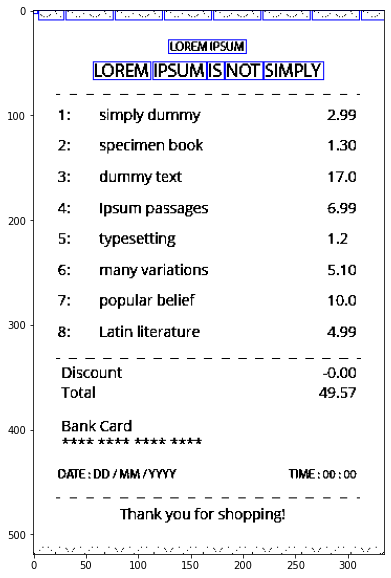

In [22]:
plt.figure(figsize = (25,10))
plt.imshow(im)
#cv2.namedWindow('detecttable', cv2.WINDOW_NORMAL)
#cv2.imwrite(‘detecttable.jpg’,im)

###  Table detection and cell recognition 

In [161]:
file=r'tabular_data.png'
img = cv2.imread(file,0)

In [162]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

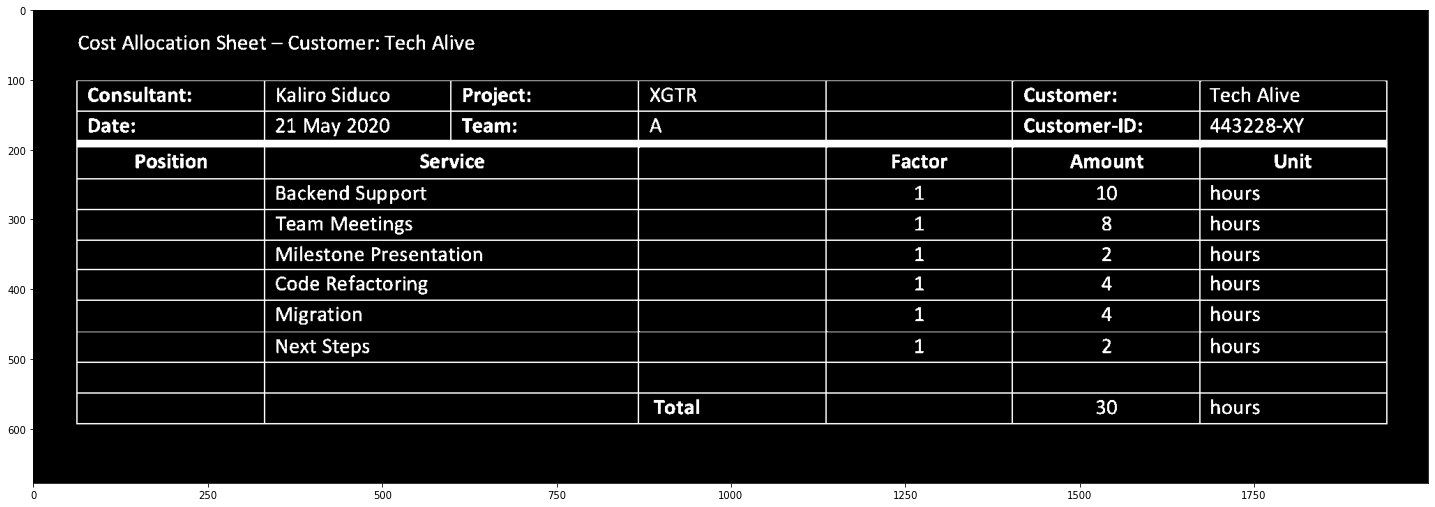

In [163]:
img_bin = 255-img_bin
cv2.imwrite('tabular_data.png',img_bin)
plt.figure(figsize = (25,10))
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [164]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

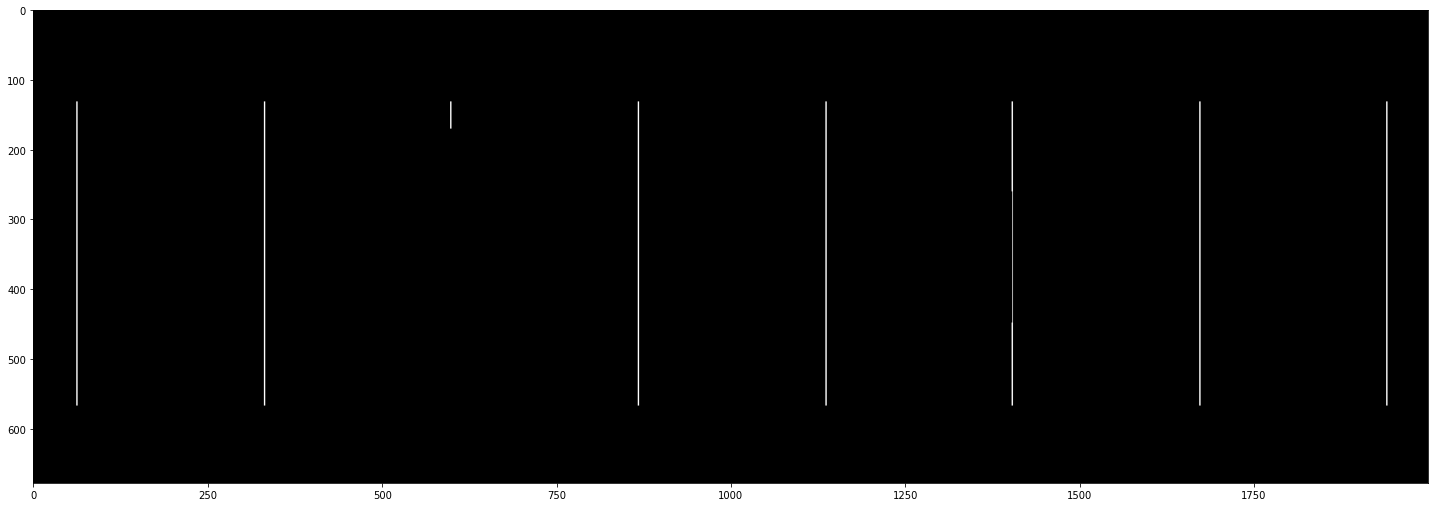

In [165]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("vertical.jpg",vertical_lines)
#Plot the generated image
plt.figure(figsize = (25,10))
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

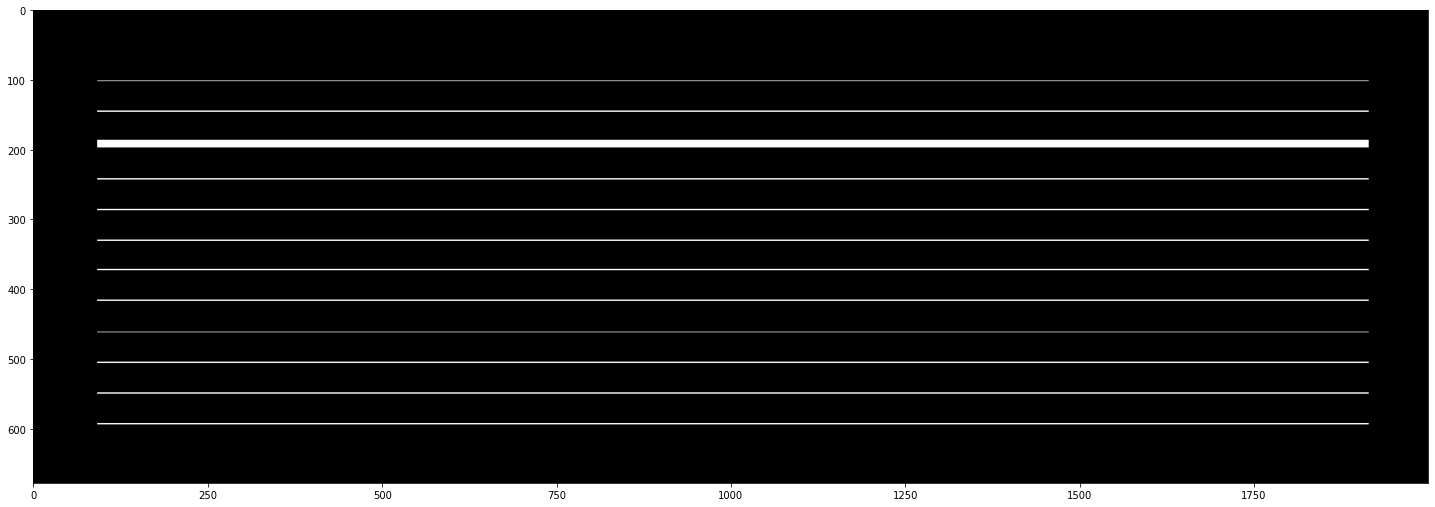

In [166]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("horizontal.jpg",horizontal_lines)
#Plot the generated image
plt.figure(figsize = (25,10))
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

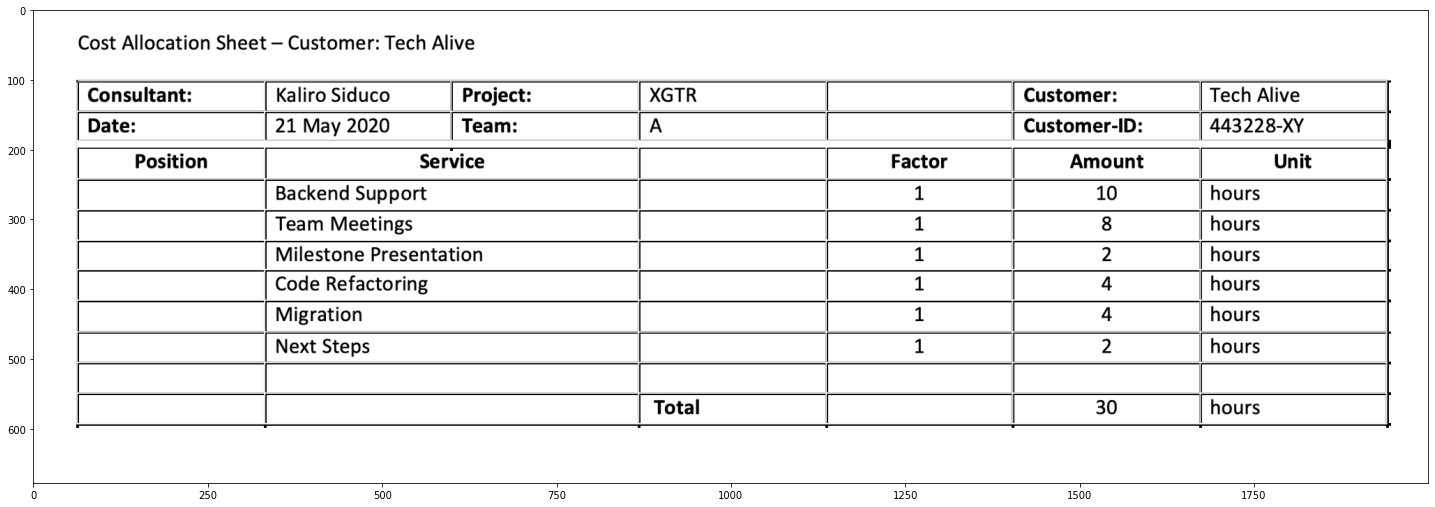

In [167]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plt.figure(figsize = (25,10))
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [168]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [169]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')

###  Allocation of the cells to the proper row and column 

In [170]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

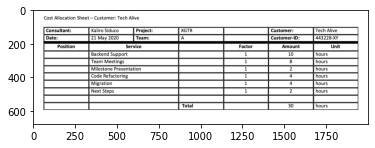

In [171]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [172]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[1676, 552, 264, 40], [1407, 552, 265, 40], [1140, 552, 263, 40], [871, 552, 265, 40], [335, 552, 532, 40], [66, 552, 265, 40]]
[[[1676, 104, 264, 40], [1407, 104, 265, 40], [1140, 104, 263, 40], [871, 104, 265, 40], [602, 104, 265, 40], [335, 104, 263, 40], [66, 104, 265, 40]], [[1676, 148, 264, 38], [1407, 148, 265, 38], [1140, 148, 263, 38], [871, 148, 265, 38], [602, 148, 265, 38], [335, 148, 263, 38], [66, 148, 265, 38]], [[1676, 199, 264, 42], [1407, 199, 265, 42], [1140, 199, 263, 42], [871, 199, 265, 42], [335, 199, 532, 42], [66, 199, 265, 42]], [[1676, 245, 264, 40], [1407, 245, 265, 40], [1140, 245, 263, 40], [871, 245, 265, 40], [335, 245, 532, 40], [66, 245, 265, 40]], [[1676, 289, 264, 40], [1407, 289, 265, 40], [1140, 289, 264, 40], [871, 289, 265, 40], [335, 289, 532, 40], [66, 289, 265, 40]], [[1676, 333, 264, 38], [1407, 333, 265, 38], [1140, 333, 264, 38], [871, 333, 265, 38], [335, 333, 532, 38], [66, 333, 265, 38]], [[1676, 375, 264, 40], [1407, 375, 265, 40], [11

In [173]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [174]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [175]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

### Extraction of each allocated cell

In [176]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
#import pytesseract
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [180]:
#Creating a dataframe of the generated OCR list
import pandas as pd
import csv
arr = np.array(outer)
#print(arr)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel('output.xlsx')

                  0                              1          2           3  \
0    Consultant:\n   Project:\n Kaliro Siduco\n    XGTR\n              
1          Date:\n        Team:\n 21 May 2020\n                        
2       Position\n                     Service\n             Factor\n   
3                              Backend Support\n                        
4                                Team Meetings\n                        
5                       Milestone Presentation\n                        
6                             Code Refactoring\n                        
7                                    Migration\n                        
8                                   Next Steps\n                        
9                                                                       
10                                                 Total\n              

                   4               5  
0       Customer:\n   Tech Alive\n

In [18]:
from PIL import Image
def list_pixel_value(image):
    WIDTH, HEIGHT = image.size
    print(image.size)
    data = list(image.getdata()) # convert image data to a list of integers
    print('Flattened array: ',data)
    print()
    # convert that to 2D list (list of lists of integers)
    data = [data[offset:offset+WIDTH] for offset in range(0, WIDTH*HEIGHT, WIDTH)]
    #print(data)
    for row in data:
        print(' '.join('{:3}'.format(value) for value in row))

In [19]:
img = Image.open('face.png').convert('L')  # convert image to 8-bit grayscale
img_resize = img.resize((30,30))
list_pixel_value(img_resize)

(30, 30)
Flattened array:  [255, 255, 255, 255, 255, 255, 255, 255, 255, 249, 173, 127, 75, 36, 20, 20, 37, 77, 128, 175, 250, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 234, 144, 37, 22, 38, 84, 127, 146, 146, 126, 83, 38, 21, 38, 146, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 174, 38, 16, 110, 182, 227, 228, 225, 224, 224, 225, 228, 227, 180, 108, 13, 41, 177, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 249, 116, 3, 87, 205, 227, 222, 216, 215, 216, 216, 216, 216, 215, 216, 223, 227, 203, 84, 2, 122, 250, 255, 255, 255, 255, 255, 255, 255, 246, 91, 13, 148, 227, 219, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 220, 226, 144, 13, 95, 248, 255, 255, 255, 255, 255, 255, 114, 11, 174, 234, 220, 215, 216, 216, 216, 216, 216, 216, 216, 216, 215, 218, 222, 220, 215, 217, 229, 168, 9, 122, 255, 255, 255, 255, 255, 175, 2, 158, 216, 170, 198, 228, 218, 216, 216, 216, 216, 216, 216, 217, 227, 205, 171, 188, 